In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import defaultdict
import heapq
%matplotlib inline

In [8]:
class MDPLanding:
    def __init__(self, L, default_reward, discount):
        
        self.states = []
        for x in range(L + 1):
            for y in range(L + 1):
                for z in range(L + 1):
                    self.states.append((x, y, z))
        
        terminal = {} 
        for state in self.states:
            x, y, z = state
            if z == 0:
                terminal[state] = -1
        
        landing_pad = (L/2, L/2, 0)
        terminal[landing_pad] = 1
        self.terminal_states = terminal
        self.default_reward = default_reward
        self.all_actions = ['Up', 'Down', 'North', 'South', 'East', 'West']
        self.discount = discount

    def actions(self, state):
        
        if state in self.terminal_states:
            return [None]
        
        (x, y, z) = state
        poss_actions = []
        if (x, y, z + 1) in self.states: 
            poss_actions.append('Up')
        if (x, y, z - 1) in self.states: 
            poss_actions.append('Down')
        if (x, y + 1, z) in self.states:
            poss_actions.append('North')
        if (x, y - 1, z) in self.states: 
            poss_actions.append('South')
        if (x + 1, y, z) in self.states: 
            poss_actions.append('East')
        if (x - 1, y, z) in self.states:
            poss_actions.append('West')
    
        return poss_actions
        
    def reward(self, state):
    
        if state not in self.terminal_states:
            return self.default_reward
        else:
            return self.terminal_states[state]
        
        
    def result(self, state, action):
    
        (x, y, z) = state
        results = {'Up': (x, y, z + 1),
                   'Down': (x, y, z - 1),
                   'North': (x, y + 1, z),
                   'South': (x, y - 1, z,),
                   'East': (x + 1, y, z),
                   'West': (x - 1, y, z)}
        
        if action == None:
            return state
        else:
            return results[action]

In [9]:
def policy_iteration(mdp):
    utility = {state: mdp.reward(state) for state in mdp.states}
    policy = {state: np.random.choice(mdp.actions(state)) for state in mdp.states}
    
    # iterate:
    while(True):
        utility = policy_evaluation(policy, utility, mdp, 25)
        noChange = True
        for state in mdp.states:
            maxUtility = -np.inf
            bestAction = policy[state]
            poss_actions = mdp.actions(state)
            for action in poss_actions:
                
                currentUtility = utility[mdp.result(state, action)]
                
                if currentUtility > maxUtility:
                    maxUtility = currentUtility
                    bestAction = action
            
            if policy[state] != bestAction:
                policy[state] = bestAction
                noChange = False
            
        if noChange == True:
            return utility, policy
    
    return utility, policy
                
        
def policy_evaluation(policy, utility, mdp, n_trials):
    for i in range(n_trials):
        for state in mdp.states:
            nextState = mdp.result(state, policy[state])
            utility[state] = mdp.reward(state) + mdp.discount * utility[nextState]
    return utility

In [10]:
mdpDrone = MDPLanding(4, -0.01, 0.999)
droneUtility, dronePolicy = policy_iteration(mdpDrone)

print('The policy for (2, 2, 1) is {}'.format(dronePolicy[(2, 2, 1)]))
print('The policy for (0, 2, 1) is {}'.format(dronePolicy[(0, 2, 1)]))
print('The policy for (2, 0, 1) is {}'.format(dronePolicy[(2, 0, 1)]))

The policy for (2, 2, 1) is Down
The policy for (0, 2, 1) is East
The policy for (2, 0, 1) is North


First one makes sense as we would just want to move down onto the landing platform (2, 2, 0). The second one makes sense as we want to move East to (2, 2, 1) to then move down onto the landing platform. Same general idea with (2, 0, 1,) but moving North. So yeah, these all make sense.

In [11]:
def run_training(mdp, n_trials):

    Q = {}
    for state in mdp.states:
        for action in mdp.actions(state):
            Q[(state, action)] = mdp.reward(mdp.result(state, action))
    policy = {state: np.random.choice(mdp.actions(state)) for state in mdp.states}
    cumulative_reward_list = []
    
    for k in range(n_trials):
        cumulative_reward = 0
        
        state = (0, 0, 0)
        while state[2] == 0:
            choice = np.random.choice(len(mdp.states))
            state = mdp.states[choice]
        reward = mdp.reward(state)
        
        for t in range(50):
            alpha = 1/(1 + t)
            
            action = policy[state]
            
            nextState = mdp.result(state, action)
            nextReward = mdp.reward(nextState)
            
            cumulative_reward += (mdp.discount**t) *reward
            
            if nextState in mdp.terminal_states:
                cumulative_reward += (mdp.discount**(t+1))*nextReward
                break
                    
            maxQ = max(Q[(nextState, nextAction)] for nextAction in mdp.actions(nextState))
            
            for nextAction in mdp.actions(nextState):
                if Q[(nextState, nextAction)] == maxQ:
                    policy[nextState] = nextAction
                    
            Q[(state, action)] +=  alpha*(reward + mdp.discount*maxQ - Q[(state, action)])
            
            
            state = nextState
            reward = mdp.reward(nextState)
        
        cumulative_reward_list.append(cumulative_reward) 
    return cumulative_reward_list

In [12]:
newmdpDrone = MDPLanding(10, -0.01, 0.999)
hopefullyNotDumbDrone = run_training(newmdpDrone, 10000)

The mean for the last 5000 trials's cumulative reward is: 0.8682489090239158


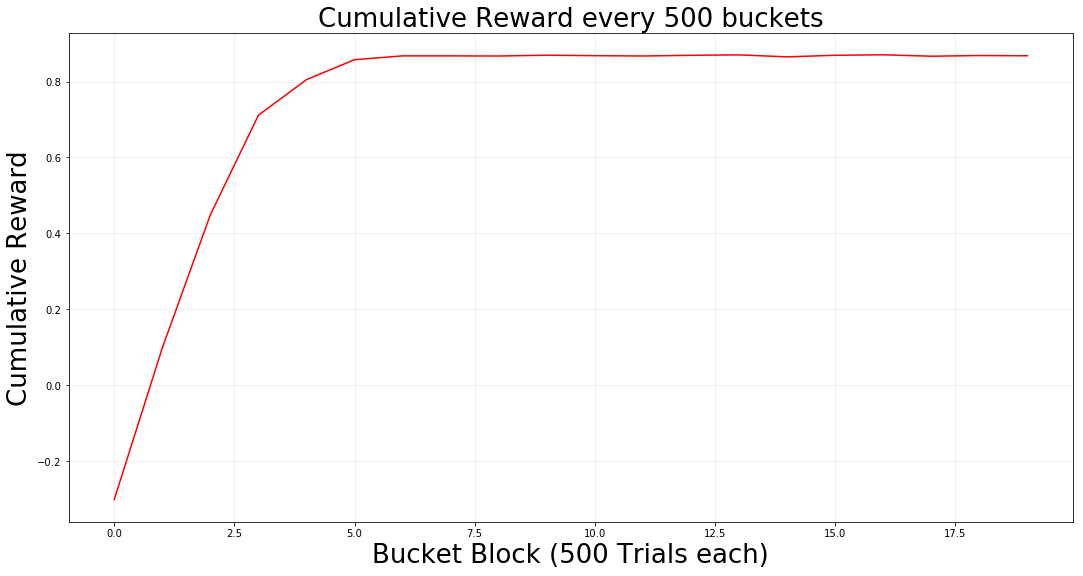

In [13]:
blocks = []
blockNum = 0
currentSum = 0
for i in range(len(hopefullyNotDumbDrone)):
    blockNum += 1
    currentSum += hopefullyNotDumbDrone[i]
    if blockNum == 500:
        blocks.append(currentSum/500)
        blockNum = 0
        currentSum = 0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

ax.plot(blocks, color = "r")
ax.set_xlabel('Bucket Block (500 Trials each)', fontsize=26)
ax.set_ylabel('Cumulative Reward', fontsize=26)
ax.set_title('Cumulative Reward every 500 buckets', fontsize=26)

ax.grid(alpha=0.25)
ax.set_axisbelow(True)


last5000Trials = np.mean(hopefullyNotDumbDrone[-5000:])
print("The mean for the last 5000 trials's cumulative reward is: {}".format(last5000Trials))